In [14]:
import numpy as np
import os
import re
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
from tqdm import tqdm
tqdm.pandas()
import time
from hlsstack.hls_funcs.smooth import despike_ts, double_savgol
import gc
from glob import glob
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
import sys
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/params/ffar_mi_params')
from ffar_mi_params_smooth import *

In [16]:
from importlib import reload
import sys
reload(sys.modules["ffar_mi_params_smooth"])

<module 'ffar_mi_params_smooth' from '/project/cper_neon_aop/hls_nrt/params/ffar_mi_params/ffar_mi_params_smooth.py'>

In [17]:
def adapt_smooth(ts, dates, despike=True, dat_thresh=None):
    ct_valid = sum(~np.isnan(ts))
    ct_total = len(ts)
    avg_gap = ct_total/ct_valid
    if ct_valid > 0:
        if avg_gap > 15:
            despike = False
        if despike:
            if dat_thresh is None:
                _dat_thresh = np.ptp(ts.values) * 0.10
            else:
                _dat_thresh = dat_thresh
            ts_ds = despike_ts(ts.values, dat_thresh=_dat_thresh, days_thresh=45)
        else:
            ts_ds = ts.values
        if avg_gap > 10:
            ts_smooth = double_savgol(ts_ds, double=True, window1_max=7, window2=31, limit=91)
        elif avg_gap > 7:
             ts_smooth = double_savgol(ts_ds, double=True, window1_max=5, window2=41, limit=91)
        elif avg_gap > 5:
             ts_smooth = double_savgol(ts_ds, double=True, window1_max=5, window2=51, limit=91)
        else:
            ts_smooth = double_savgol(ts_ds, double=False, window2=51, limit=91)
    else:
        ts_smooth = ts
    return pd.Series(ts_smooth, ts.index.get_level_values(-1))

In [18]:
fLIST = glob(inPATH_wc)
df = pd.read_csv(inPATH_dat, parse_dates=[date_col])

In [19]:
if preprocess is not None:
    df = preprocess(df)

In [20]:
df.head(5)

,Unnamed: 0,Block_name,Treatment,Date,Site,Ranch,Year,Low.reading_mean,Low.reading_sd,High.reading_mean,...,High.rounded_10_mean,High.rounded_10_sd,Sample_ID_vor,mean_biomass,sd_biomass,Sample_ID_bio,X_coord,Y_coord,ID,Block_Id
0,1,7,AD,2022-06-06,MI,LC,2022,45.727273,5.666794,85.363636,...,87.272727,6.310851,2022-06-06_MI_LC_AD_7,1586.666667,329.524911,2022-06-06_MI_LC_AD_7,-85.213424,44.306466,7_AD_2022,7_AD
1,2,7,AD,2022-08-22,MI,LC,2022,21.600000,5.963105,65.700000,...,68.666667,24.315928,2022-08-22_MI_LC_AD_7,1756.666667,314.710064,2022-08-22_MI_LC_AD_7,-85.213424,44.306466,7_AD_2022,7_AD
2,3,7,AD,2023-09-19,MI,LC,2023,17.266667,2.947042,26.600000,...,30.333333,4.901325,2023-09-19_MI_LC_AD_7,1320.000000,289.551377,2023-09-19_MI_LC_AD_7,-85.213424,44.306466,7_AD_2023,7_AD
3,4,7,AD,2023-07-20,MI,LC,2023,6.466667,2.979624,22.133333,...,25.333333,16.965143,2023-07-20_MI_LC_AD_7,926.666667,528.494718,2023-07-20_MI_LC_AD_7,-85.213424,44.306466,7_AD_2023,7_AD
4,5,7,AD,2023-05-24,MI,LC,2023,25.300000,6.086446,47.033333,...,52.000000,8.051558,2023-05-24_MI_LC_AD_7,2346.666667,494.233413,2023-05-23_MI_LC_AD_7,-85.213424,44.306466,7_AD_2023,7_AD


In [21]:
yr = 2022

In [22]:
# get list of files that match year based on path
fLIST_yr = [x for x in fLIST if str(yr) in os.path.basename(x).split('_')]

# combine all individual tile files into one dataframe
df_yr = pd.concat([pd.read_csv(x, parse_dates=[1]) for x in fLIST_yr])

# rename columns to match ground data
df_yr = df_yr.rename(columns={'time': date_col,
                              'Plot': id_col})

# convert date to datetime
df_yr[date_col] = pd.to_datetime(df_yr[date_col])

# remove all non-plot data
#df_yr = df_yr[df_yr[id_col] != 'UNK']

# remove any dates where bands are negative
df_yr = df_yr[~((df_yr[band_list] < 0).any(axis=1))]

# drop any duplicates by taking mean for each plot and date (might exist e.g., from plot on edge of tile during extraction)
df_yr = df_yr.groupby([id_col, date_col]).mean().reset_index()

# get missing dates for gap-filling
dates_missing = [x for x in pd.date_range(df_yr[date_col].min(), df_yr[date_col].max()).date if x not in df_yr[date_col].dt.date.unique()]

# convert missing dates to a dataframe for combining with veg index data
df_missing = pd.DataFrame({
    id_col: list(chain.from_iterable([list(np.repeat(x, len(dates_missing))) for x in df_yr[id_col].unique()])),
    date_col: list(chain.from_iterable(dates_missing for x in df_yr[id_col].unique()))})

df_missing[date_col] = pd.to_datetime(df_missing[date_col])

# combine into one dataframe for gapfilling
df_yr_ts = pd.concat([df_yr, df_missing]).sort_values([id_col, date_col])

# apply Bolton mask to extracted values
if mask_bolton_by_id:
    ps_bolton = df_yr_ts.groupby(id_col).progress_apply(lambda x: bolton_mask_np(x['BLUE'], x['SWIR2']))
    df_yr_ts.loc[df_yr_ts[ps_bolton.droplevel(0) == 1.0].index, list(veg_dict.keys()) + band_list] = np.nan

# smooth all vegetation indices to gapfill
print('Smoothing vegetation indices')
for vegidx in tqdm(veg_list):
    #df_yr_ts[vegidx + '_smooth'] = df_yr_ts.groupby(id_col)[vegidx].transform(lambda x: double_savgol(x.values))
    vals_smooth_yr = df_yr_ts.groupby(id_col).apply(lambda x: adapt_smooth(x[vegidx], pd.to_datetime(x[date_col])))
    if vals_smooth_yr.index.nlevels > 1:
        df_yr_ts[vegidx + '_smooth'] = vals_smooth_yr.droplevel(list(np.arange(vals_smooth_yr.index.nlevels-1)))
    else:
        df_yr_ts[vegidx + '_smooth'] = vals_smooth_yr.values.squeeze()
print('Smoothing individual bands')
for band in tqdm(band_list):
    #df_yr_ts[band + '_smooth'] = df_yr_ts.groupby(id_col)[band].transform(lambda x: double_savgol(x.values))
    vals_smooth_yr = df_yr_ts.groupby(id_col).apply(lambda x: adapt_smooth(x[band], pd.to_datetime(x[date_col])))
    if vals_smooth_yr.index.nlevels > 1:
        df_yr_ts[band + '_smooth'] = vals_smooth_yr.droplevel(list(np.arange(vals_smooth_yr.index.nlevels-1)))
    else:
        df_yr_ts[band + '_smooth'] = vals_smooth_yr.values.squeeze()

Smoothing vegetation indices


100%|██████████| 22/22 [00:07<00:00,  3.00it/s]


Smoothing individual bands


100%|██████████| 6/6 [00:01<00:00,  3.34it/s]


In [23]:
# look for any missing data
df_yr_ts[df_yr_ts['NDVI_smooth'].isnull()].sort_values(id_col)

,ID,Date,NDVI,DFI,NDTI,SATVI,NDII7,SAVI,RDVI,MTVI1,...,BAI_146_smooth,BAI_236_smooth,BAI_246_smooth,BAI_346_smooth,BLUE_smooth,GREEN_smooth,RED_smooth,NIR1_smooth,SWIR1_smooth,SWIR2_smooth


In [24]:
df_yr_ts[df_yr_ts.duplicated(subset=[id_col, date_col], keep=False)].sort_values(id_col)

,ID,Date,NDVI,DFI,NDTI,SATVI,NDII7,SAVI,RDVI,MTVI1,...,BAI_146_smooth,BAI_236_smooth,BAI_246_smooth,BAI_346_smooth,BLUE_smooth,GREEN_smooth,RED_smooth,NIR1_smooth,SWIR1_smooth,SWIR2_smooth


In [25]:
df_yr_ts = df_yr_ts.reset_index()

<AxesSubplot:xlabel='Date', ylabel='SWIR1_smooth'>

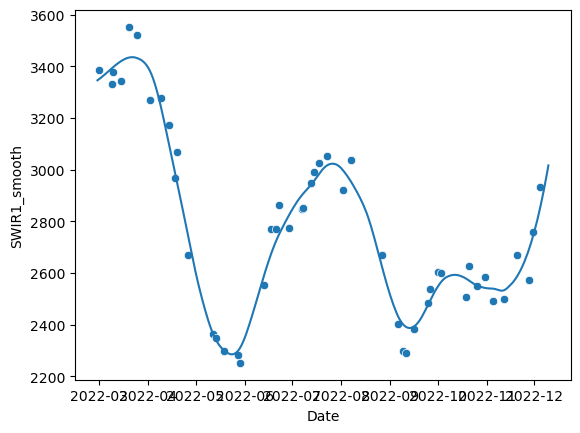

In [26]:
plot = df_yr_ts[id_col].unique()[10]
plot = '1_AD_2022'
x_col = 'SWIR1'
p = sns.lineplot(x=date_col, y=x_col + '_smooth', data=df_yr_ts[df_yr_ts[id_col] == plot])
sns.scatterplot(x=date_col, y=x_col, data=df_yr[df_yr[id_col] == plot], ax=p)

In [27]:
x_col = 'TCWI'
sns.scatterplot(x=x_col, y=y_col, data=df_out, alpha=0.2, linewidth=0, s=10)
plt.yscale('log')

NameError: name 'df_out' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
#sns.scatterplot(x=x_col, y=y_col, data=df_out, hue='Year', ax=ax)
#df_out.apply(lambda x: ax.text(x[x_col],  x[y_col], x[id_col]), axis=1)
#plt.yscale('log')